In [1]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
os.environ["OPENAI_API_KEY"] = ""

loader = TextLoader("./data/Ragas/testContext.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

#imports necessary libraries, sets the OpenAI API key securely, loads a text document, and splits it into smaller chunks for further processing

In [2]:
chunks[0]

#see first chunck

Document(metadata={'source': './data/Ragas/testContext.txt'}, page_content='NeoSynth Solutions is a global leader in developing advanced AI-driven solutions aimed at creating sustainable and innovative technologies for urban environments. The company operates through three main divisions:\n\t1.\tAI Ethics and Autonomous Systems:')

In [3]:
for document in chunks:
    document.metadata["file_name"] = document.metadata["source"]

#RAGAS expects a file_name dict as key (needed to work)

In [4]:
#from ragas.testset import TestsetGenerator
#from ragas.llms import LangchainLLMWrapper
#from ragas.embeddings import LangchainEmbeddingsWrapper
#from langchain.embeddings import OllamaEmbeddings
#from langchain_openai import ChatOpenAI

#generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
#generator_embeddings = LangchainEmbeddingsWrapper(OllamaEmbeddings(model="nomic-embed-text"))
#generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
#dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

#sets up the language model and embeddings wrappers, initializes the test set generator, and generates a test dataset from the loaded document chunks
#this is to create artificial questions from the context to test it

In [5]:
#dataset.to_pandas()
#see artificial questions

In [6]:
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM
from langchain.embeddings import OllamaEmbeddings
# Sparse retrieval
from langchain.retrievers import BM25Retriever

embedding = OllamaEmbeddings(model="nomic-embed-text")
model = OllamaLLM(model="deepseek-r1:1.5b")
#model = ChatOpenAI(model="gpt-4o-mini")

# Dense (Chroma)
vectorstore = Chroma.from_documents(chunks, embedding)
dense_retriever = vectorstore.as_retriever()

# Sparse (BM25)
bm25_retriever = BM25Retriever.from_documents(chunks)

#imports necessary modules, initializes the embedding and language models, 
#creates a Chroma vector store from the document chunks using the specified embeddings, 
#and sets up a retriever to enable efficient querying of the vector store

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_34124/1172113931.py:8: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding = OllamaEmbeddings(model="nomic-embed-text")


In [7]:
from typing import List, Dict, Any
from langchain.schema import Document
import numpy as np

class CustomHybridRetriever:
    def __init__(self, dense_retriever, sparse_retriever, dense_weight: float = 0.5, k: int = 5):
        self.dense_retriever = dense_retriever
        self.sparse_retriever = sparse_retriever
        self.dense_weight = dense_weight
        self.sparse_weight = 1 - dense_weight
        self.k = k

    def get_relevant_documents(self, query: str) -> List[Document]:
        # Retrieve documents from both retrievers
        dense_docs = self.dense_retriever.get_relevant_documents(query)
        sparse_docs = self.sparse_retriever.get_relevant_documents(query)

        # Combine scores using a simple linear scoring mechanism
        doc_scores = {}
        for i, doc in enumerate(dense_docs):
            score = 1.0 - (i / len(dense_docs))
            doc_scores[doc.page_content] = self.dense_weight * score

        for i, doc in enumerate(sparse_docs):
            score = 1.0 - (i / len(sparse_docs))
            if doc.page_content in doc_scores:
                doc_scores[doc.page_content] += self.sparse_weight * score
            else:
                doc_scores[doc.page_content] = self.sparse_weight * score

        # Sort and select top k documents
        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        result_docs = []
        seen_content = set()
        all_docs = dense_docs + sparse_docs
        docs_lookup = {doc.page_content: doc for doc in all_docs}
        for content, _ in sorted_docs:
            if content not in seen_content and len(result_docs) < self.k:
                result_docs.append(docs_lookup[content])
                seen_content.add(content)
        return result_docs

    def invoke(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """
        Provides an invoke interface for the custom hybrid retriever.
        """
        query = inputs.get("query", "")
        documents = self.get_relevant_documents(query)
        return {"documents": documents}

# Example usage:
hybrid_retriever = CustomHybridRetriever(
    dense_retriever=dense_retriever,      # your dense retriever instance
    sparse_retriever=bm25_retriever,        # your sparse retriever instance
    dense_weight=0.5,  # weight of dense retriever
    k=5              # number of results to return
)

In [8]:
from typing import Dict, Any, List
from langchain.schema import Document

class RunnableRetriever:
    def __init__(self, retriever):
        self.retriever = retriever

    def invoke(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """
        This method wraps the retriever's get_relevant_documents method.
        It extracts the query from the input dict and returns a dict with the results.
        """
        query = inputs.get("query", "")
        documents: List[Document] = self.retriever.get_relevant_documents(query)
        return {"documents": documents}

    def __call__(self, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """
        Allow the instance to be called directly, delegating to invoke.
        """
        return self.invoke(inputs)

In [9]:
# Assuming dense_retriever and bm25_retriever are already defined and implement get_relevant_documents

# Wrap the existing retrievers so they are callable:
runnable_dense = RunnableRetriever(dense_retriever)
runnable_sparse = RunnableRetriever(bm25_retriever)

# Wrap your custom hybrid retriever
runnable_hybrid = RunnableRetriever(
    CustomHybridRetriever(
        dense_retriever=dense_retriever,
        sparse_retriever=bm25_retriever,
        dense_weight=0.5,
        k=5
    )
)

In [10]:
# Dictionary mapping strategy names to runnable retrievers
retriever = {
    "dense": runnable_dense,
    "sparse": runnable_sparse,
    "hybrid": runnable_hybrid,
}

In [11]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

#imports the PromptTemplate class, defines a template that instructs the language model to answer questions based 
#only on the provided context, and initializes a PromptTemplate instance with specified input variables for “context” and “question”

In [12]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

def rag_chain(strategy="dense"):
    """
    Return a chain that uses either 'dense', 'sparse', or 'hybrid'
    depending on the argument.
    """

    # Fallback to dense if unknown strategy
    selected_retriever = retriever.get(strategy, dense_retriever)

    rag_chain = (
        {
            "context": selected_retriever,       # This is where you specify which retriever
            "question": RunnablePassthrough()
        }
        | prompt
        | model
        | StrOutputParser()
    )
    return rag_chain


In [13]:
import pandas as pd

df = pd.read_csv("data/Ragas/qa.csv", delimiter=",")
questions = df["question"].tolist()
ground_truth = df["ground_truth"].tolist()

#constructs a RAG chain by combining a retriever for fetching relevant context, a prompt template for formatting questions, 
#a language model for generating responses, and an output parser to process the model’s output. Finally, it prints the configured RAG chain

In [14]:
ground_truth

#see ground truths

['AI ClearPath',
 'Germany',
 'Yes',
 '45%',
 'VisionAI Labs',
 'HealthSphere',
 'Collaboration with TechRise University',
 '60%',
 'No',
 'Optimizing energy distribution for smart cities']

In [15]:
from datasets import Dataset

# Instantiate your chain once (if it depends on a strategy)
chain_instance = rag_chain(strategy="dense")

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    
    # Call invoke on the chain instance, not on the function
    answer_result = chain_instance.invoke({"query": query})
    # Use a type check to determine whether answer_result is a dict or a string
    answer = answer_result.get("answer", answer_result) if isinstance(answer_result, dict) else answer_result
    data["answer"].append(answer)
    
    # If your retriever is also a dictionary of runnables, select the proper one and call invoke similarly:
    retriever_output = retriever["hybrid"].invoke({"query": query})
    docs = retriever_output.get("documents", [])
    data["contexts"].append([doc.page_content for doc in docs])

# Create the Dataset from the dictionary
dataset = Dataset.from_dict(data)

# Extract the first entry
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
print(first_entry)

/Users/nicolocampagnoli/miniconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_34124/1351262405.py:14: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents: List[Document] = self.retriever.get_relevant_documents(query)


{'question': 'Which NeoSynth project in 2024 focused on improving the interpretability of AI systems in urban traffic management?', 'answer': '<think>\nOkay, so I\'m trying to answer this question about NeoSynth\'s projects from 2024 that focus on improving the interpretability of AI systems. Let me go through each document one by one.\n\nFirst, looking at the first document: It talks about NeoSynth expanding its global presence with a 2024 partnership with VisionAI Labs. The page content mentions integrating AI into public transportation for underdeveloped regions. Hmm, but that\'s more about collaboration than interpretability of AI systems specifically.\n\nThe second document is similar. It starts with two bullet points: one about launching the "AI ClearPath" initiative to enhance interpretability and another about renewable energy optimization. So here, it explicitly mentions AI ClearPath, which seems to focus on improving AI in traffic systems. That\'s a strong candidate for inter

In [16]:
print(data['answer'][0])

<think>
Okay, so I'm trying to answer this question about NeoSynth's projects from 2024 that focus on improving the interpretability of AI systems. Let me go through each document one by one.

First, looking at the first document: It talks about NeoSynth expanding its global presence with a 2024 partnership with VisionAI Labs. The page content mentions integrating AI into public transportation for underdeveloped regions. Hmm, but that's more about collaboration than interpretability of AI systems specifically.

The second document is similar. It starts with two bullet points: one about launching the "AI ClearPath" initiative to enhance interpretability and another about renewable energy optimization. So here, it explicitly mentions AI ClearPath, which seems to focus on improving AI in traffic systems. That's a strong candidate for interpretability.

Looking at the third document: It's more about NeoSynth's projects and their outputs like reports and whitepapers. They mention 2024 Ethic

In [17]:
from datasets import Dataset
import pandas as pd
import re

def clean_thinks(dataset: Dataset) -> Dataset:
    df = pd.DataFrame(dataset)
    
    # Simple pattern to match exactly between <think> tags
    pattern = r'<think>.*?</think>'
    
    # Clean answers
    df['answer'] = df['answer'].apply(lambda x: re.sub(pattern, '', x, flags=re.DOTALL).strip())
    
    # Print example for verification
    print(f"\nCleaned answer:\n{df['answer'].iloc[0]}")
    
    return Dataset.from_pandas(df)

# Usage
cleaned_dataset = clean_thinks(dataset)


Cleaned answer:
The NeoSynth project that focused on improving the interpretability of AI systems in urban traffic management is:

- **AI ClearPath**.

This initiative was discussed in two documents, where it is highlighted as enhancing the interpretability aspect through its role in reducing accidents. The third document further elaborates with a 2024 Ethics report, which ties into this focus on improving AI's interpretability.


In [24]:
print(cleaned_dataset['answer'][0])

The NeoSynth project that focused on improving the interpretability of AI systems in urban traffic management is:

- **AI ClearPath**.

This initiative was discussed in two documents, where it is highlighted as enhancing the interpretability aspect through its role in reducing accidents. The third document further elaborates with a 2024 Ethics report, which ties into this focus on improving AI's interpretability.


In [18]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

your_evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
#your_evaluator_llm = LangchainLLMWrapper(model)

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=cleaned_dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=your_evaluator_llm
)

#sets up an evaluator with the specified language model, and evaluates the dataset using a
#set of metrics including context precision, context recall, faithfulness, and answer relevancy

/Users/nicolocampagnoli/miniconda3/envs/ragas/lib/python3.10/site-packages/ragas/metrics/__init__.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from ragas.metrics._answer_correctness import AnswerCorrectness, answer_correctness
/Users/nicolocampagnoli/miniconda3/envs/ragas/lib/python3.10/site-packages/ragas/metrics/__init__.py:4: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pyd

In [19]:
result.to_pandas()

#see evaluation results

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Which NeoSynth project in 2024 focused on impr...,The NeoSynth project that focused on improving...,[•\tA flagship project involved launching the ...,AI ClearPath,0.833333,1.0,0.666667,0.985005
1,"In 2023, did NeoSynth's GreenFlow platform ach...","Yes, according to the provided documents, in 2...","[•\tIn 2023, GreenFlow was adopted in Germany ...",Germany,1.000000,1.0,0.800000,0.898781
2,Did NeoSynth announce its partnership with Gre...,"Yes, NeoSynth announced a partnership with Gre...","[•\tPrior to this, in June 2023, NeoSynth anno...",Yes,1.000000,1.0,1.000000,0.998123
3,What percentage of cities in the United States...,The percentage of cities in the United States ...,"[•\tIn 2023, GreenFlow was adopted in Germany ...",45%,1.000000,1.0,0.333333,0.993890
4,Which company partnered with NeoSynth in 2024 ...,NeoSynth partnered with **VisionAI Labs** and ...,[NeoSynth continues to expand its global prese...,VisionAI Labs,1.000000,1.0,0.600000,0.969653
5,What is the name of NeoSynth’s platform for pe...,The name of NeoSynth’s platform for personaliz...,"[•\tIn 2023, GreenFlow was adopted in Germany ...",HealthSphere,1.000000,1.0,1.000000,0.998862
6,Which NeoSynth initiative in 2024 focused on r...,The correct answer is:\n\n**Which NeoSynth ini...,"[•\tIn 2024, NeoSynth partnered with TechRise ...",Collaboration with TechRise University,1.000000,1.0,0.500000,0.977093
7,What percentage of cities in Germany adopted G...,The first document explicitly states that in 2...,"[•\tIn 2023, GreenFlow was adopted in Germany ...",60%,1.000000,1.0,0.500000,1.000000
8,Does NeoSynth operate in the deep-sea explorat...,"Based on the provided context, NeoSynth does n...",[NeoSynth frequently publishes annual reports ...,No,0.000000,1.0,1.000000,0.000000
9,What is the primary focus of the GreenFlow pla...,The primary focus of the GreenFlow platform is...,"[•\tIn 2023, GreenFlow was adopted in Germany ...",Optimizing energy distribution for smart cities,0.333333,1.0,0.000000,1.000000


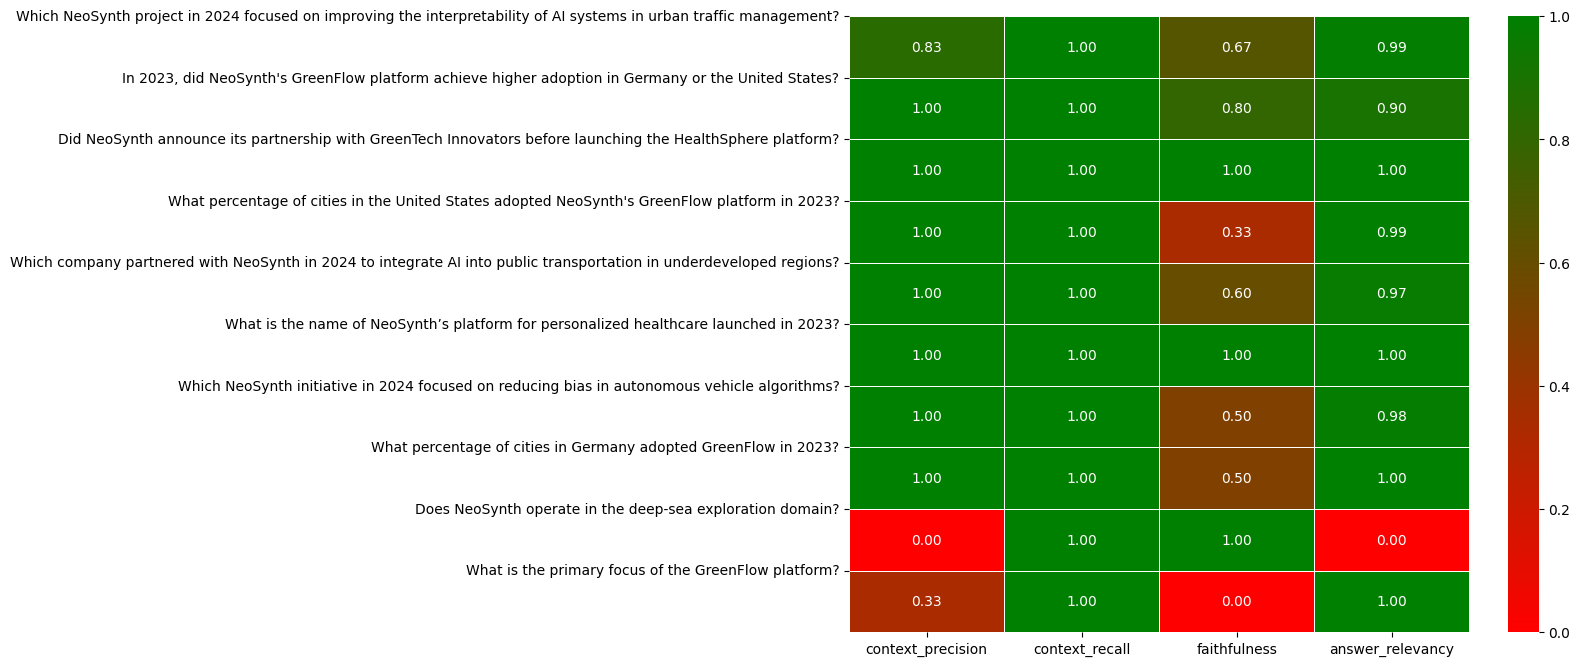

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "context_precision",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["question"])), labels=df["question"], rotation=0)

plt.show()

#visualizes the evaluation results using a heatmap to display context precision, context recall, faithfulness, and answer relevancy metrics

In [22]:
df[['context_precision', 'context_recall', 'faithfulness', "answer_relevancy"]].mean()

#see average evaluation results

context_precision    0.816667
context_recall       1.000000
faithfulness         0.640000
answer_relevancy     0.882141
dtype: float64